In [1]:
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
from paper_changes import *
# manual feature selection
from collections import defaultdict
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.decomposition import SparsePCA
from scipy.stats import zscore

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [5]:
import pickle
import pandas as pd

def load_data(field='absolute', zscore=True):
    infile = '/userdata/pdaly/supereeg/results/samp100_2h_54pid_pos-1.18.power.pkl'
    data = pickle.load(open(infile, 'rb'))
    labels = pd.read_csv('/home/kscangos/Sandbox/full_patient_list_pd_feb.csv', index_col=0)
    labels['pid'] = labels.index.map(lambda pid: pid[2:])
    df = data[field]
    df = df.reset_index().merge(labels[['pid', 'dep']], left_on='index',
                           right_on='pid').set_index('index').drop('pid', axis=1)
    df.rename(columns={'Dep': 'dep'}, inplace=True)
    df.drop(['92','111','119','131','135','27','115','130',
             '144','158','162','170','183'], axis=0, inplace=True)
    X, y = df.drop('dep', axis=1), df.dep
    if zscore:
        X = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns, index=X.index)
    return X, y

In [6]:
X, y = load_data(field='relative', zscore=False)

In [2]:
X, y = load_data()

Text(0.5, 1.0, 'Feature Correlation Heatmap')

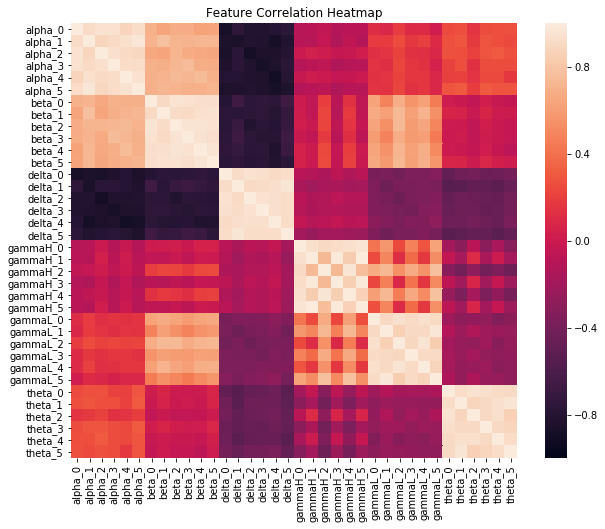

In [3]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(X.corr(), vmin=-1, vmax=1, ax=ax)

ax.set_title('Feature Correlation Heatmap')

## Logistic Regression

In [4]:
df = pd.read_csv('/home/pdaly/supereeg/data/apr6_100samp_2h_ml/df.csv', index_col=0)

X = pd.DataFrame(PCA().fit_transform(df.drop('dep', axis=1).apply(zscore)))
y = df['dep']

In [5]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

## Quick Model Check
1. PCA -> CV with RF/Logit: 0.824
2. PCA -> CV with Logit: 0.774
3. CV with PCA(n=10)/Logit: 0.774
4. PCA(n=10) -> CV with Logit: 0.774

In [6]:
get_feats_norf = lambda pipe: pd.Series(np.squeeze(pipe.steps[0][1].coef_), index=X.columns)

In [7]:
class Metrics:
    '''would dod this for test, but don't want to rewrite it'''
    def __init__(self):
        self.recalls = list()
        self.precisions = list()
        self.accuracies = list()
        self.balanced_accuracies = list()
        self.rocs = list()
    
    def add_results(self, actual, preds, probs):
        self.recalls.append(recall_score(actual, preds))
        self.precisions.append(precision_score(actual, preds))
        self.accuracies.append(accuracy_score(actual, preds))
        self.balanced_accuracies.append(balanced_accuracy_score(actual, preds))
        self.rocs.append(roc_auc_score(actual, probs))
    
    def avg_all(self):
        self.avgs = pd.Series({
            'recall': np.mean(self.recalls),
            'precision': np.mean(self.precisions),
            'accuracy': np.mean(self.accuracies),
            'balanced_accuracy': np.mean(self.balanced_accuracies),
            'roc': np.mean(self.rocs)})
        self.recall = self.avgs.recall
        self.precision = self.avgs.precision
        self.accuracy = self.avgs.accuracy
        self.balanced_accuracy = self.avgs.balanced_accuracy
        self.roc = self.avgs.roc

In [8]:
def crossval(X, y, pipe, get_feats, ite=100, verbose=True, null=False):
    feats = defaultdict(list)
    preds = list()
    probs = list()
    model = 'logit'
    trm = Metrics()
    ys = list()
    for _ in tqdm(range(ite)) if verbose else range(ite):
        if null:
            y = y.sample(frac=1)
        ys.extend(y)
        for train_idx, test_idx in LeaveOneOut().split(X):
            pipe.fit(X.iloc[train_idx], y.iloc[train_idx])
            trm.add_results(y.iloc[train_idx],
                pipe.predict(X.iloc[train_idx]), 
                pipe.predict_proba(X.iloc[train_idx])[:, 1])
            pred = pipe.predict(X.iloc[test_idx])[0]
            proba = pipe.predict_proba(X.iloc[test_idx])[0][1]
            preds.append(pred)
            probs.append(proba)
            fs = get_feats(pipe)
            for f in fs.index:
                if abs(fs[f]) > 0:
                    feats[f].append(fs[f])
    bm = pd.DataFrame(list(zip(preds, probs, ys)), 
                      columns=['pred', 'proba', 'actual'])
    trm.avg_all()
    return bm, trm, feats


def print_res(bm, trm, model='logit'):
    rs = recall_score(bm['actual'], bm['pred'])
    ps = precision_score(bm['actual'], bm['pred'])
    acc = accuracy_score(bm['actual'], bm['pred'])
    bacc = balanced_accuracy_score(bm['actual'], bm['pred'])
    roc = roc_auc_score(bm['actual'], bm['proba'])
    
    results = trm.avgs.to_frame().rename(columns={0: 'train'})
    results['test'] = 0
    results.loc['accuracy', 'test'] = acc
    results.loc['balanced_accuracy', 'test'] = bacc
    results.loc['precision', 'test'] = ps
    results.loc['recall', 'test'] = rs
    results.loc['roc', 'test'] = roc
    
    print(results.round(3))
    #print(model)
    #print('------------------------')
    #print('Recall       : {:1.3f}'.format(rs))
    #print('Precision    : {:1.3f}'.format(ps))
    #print('Accuracy     : {:1.3f}'.format(acc))
    #print('Bal. Accuracy: {:1.3f}'.format(bacc))
    #print('ROC AUC.     : {:1.3f}\n'.format(roc))
    
    
def plot_res(feats):
    fig, axs = plt.subplots(1, 2, figsize=(14, 4))

    fsrs['count'].apply(lambda v: v/4000).plot(kind='bar', ax=axs[0]);
    axs[0].set_ylabel('Percent of Models w/ Feature')
    fsrs['mean'].plot(kind='bar', yerr=fsrs['std'], ax=axs[1])
    axs[1].set_ylabel('Avg Model Weight')

    sns.despine()

### PCA -> CV: RF(10)/Logit

100%|██████████| 100/100 [10:51<00:00,  6.52s/it]


                   train   test
accuracy           0.831  0.829
balanced_accuracy  0.827  0.823
precision          0.841  0.833
recall             0.864  0.869
roc                0.878  0.793
           mean       std  count
pc_1  -0.027529  0.108050   1420
pc_10 -0.028819  0.766152   1159
pc_11 -0.216487  0.877932   1027
pc_12  0.417784  0.912888    804
pc_13 -0.258269  0.827627    577
pc_14 -0.272363  0.712145    392
pc_15  0.058176  0.675474    352
pc_16 -0.115399  0.852604    248
pc_17 -0.292843  0.600652    299
pc_18  0.254028  0.636305    185
pc_19 -0.092570  0.616869     86
pc_2   0.010937  0.145680   1184
pc_3   0.001091  0.235231   1183
pc_4   0.124435  0.322520   1203
pc_5   0.054094  0.672340   1575
pc_6  -0.104382  0.716515   1211
pc_7  -0.016677  0.775329   1266
pc_8  -0.349953  0.765182   1101
pc_9   0.016036  0.827165   1012


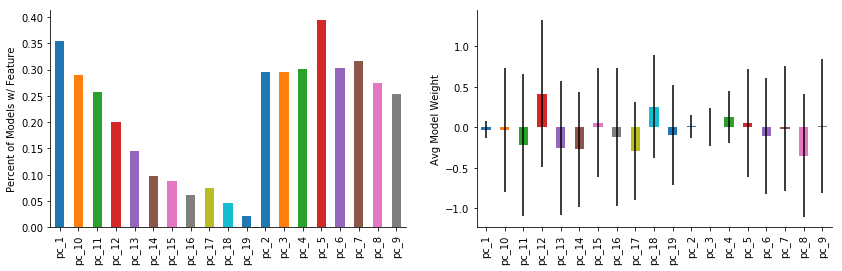

In [120]:
X, y = load_data()
X = pd.DataFrame(PCA().fit_transform(X), columns=['pc_' + str(i+1) for i in range(X.shape[1])])

pipe = Pipeline([('rf_select', SelectFromModel(RandomForestClassifier(n_estimators=200), max_features=10)),
                 ('clf', LogisticRegression(C=1, penalty='l1', class_weight='balanced', solver='liblinear',
                                                max_iter=100, tol=1e-6))])
                 
get_feats = lambda pipe: pd.Series(np.squeeze(pipe.steps[-1][1].coef_), 
                                   index=X.columns[pipe.steps[-2][1].get_support()])

bm_best, trm_best, feats_best = crossval(X, y, pipe, get_feats, ite=100)

print_res(bm_best, trm_best)

fsrs_best = pd.DataFrame.from_dict({v: [np.mean(l), np.std(l), len(l)] for v, l in feats.items()},
                              columns=['mean', 'std', 'count'], orient='index').sort_index()
print(fsrs_best)

plot_res(fsrs_best)

In [130]:
# t test vs null
from rsd.utils import chunker

null = {'bac': list(),
        'rec': list(),
        'prec': list(),
        'auc': list()}
best = {'bac': list(),
        'rec': list(),
        'prec': list(),
        'auc': list()}
for ch in chunker(bm, 41):
    null['bac'].append(balanced_accuracy_score(ch['actual'], ch['pred']))
    null['rec'].append(recall_score(ch['actual'], ch['pred']))
    null['prec'].append(precision_score(ch['actual'], ch['pred']))
    null['auc'].append(roc_auc_score(ch['actual'], ch['proba']))
    
for ch in chunker(bm_best, 41):
    best['bac'].append(balanced_accuracy_score(ch['actual'], ch['pred']))
    best['rec'].append(recall_score(ch['actual'], ch['pred']))
    best['prec'].append(precision_score(ch['actual'], ch['pred']))
    best['auc'].append(roc_auc_score(ch['actual'], ch['proba']))

In [132]:
from scipy.stats import ttest_ind

In [139]:
for metric in null:
    t, p = ttest_ind(null[metric], best[metric])
    print('{} - t: {}, p: {}'.format(metric, round(t, 3), p))

rec - t: -30.61, p: 5.2454146639399725e-77
bac - t: -27.445, p: 2.1066606833805943e-69
prec - t: -22.567, p: 1.21407494381748e-56
auc - t: -21.114, p: 1.3615410030410773e-52


### PCA -> CV: RF(10)/Logit (NULL)

100%|██████████| 100/100 [05:51<00:00,  3.51s/it]


                   train   test
accuracy           0.690  0.490
balanced_accuracy  0.693  0.491
precision          0.751  0.552
recall             0.669  0.486
roc                0.765  0.490
           mean       std  count
pc_1  -0.027529  0.108050   1420
pc_10 -0.028819  0.766152   1159
pc_11 -0.216487  0.877932   1027
pc_12  0.417784  0.912888    804
pc_13 -0.258269  0.827627    577
pc_14 -0.272363  0.712145    392
pc_15  0.058176  0.675474    352
pc_16 -0.115399  0.852604    248
pc_17 -0.292843  0.600652    299
pc_18  0.254028  0.636305    185
pc_19 -0.092570  0.616869     86
pc_2   0.010937  0.145680   1184
pc_3   0.001091  0.235231   1183
pc_4   0.124435  0.322520   1203
pc_5   0.054094  0.672340   1575
pc_6  -0.104382  0.716515   1211
pc_7  -0.016677  0.775329   1266
pc_8  -0.349953  0.765182   1101
pc_9   0.016036  0.827165   1012


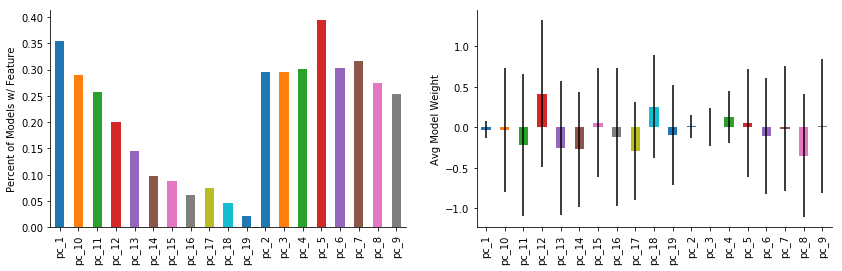

In [117]:
X, y = load_data()
X = pd.DataFrame(PCA().fit_transform(X), columns=['pc_' + str(i+1) for i in range(X.shape[1])])

pipe = Pipeline([('rf_select', SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=10)),
                 ('clf', LogisticRegression(C=1, penalty='l1', class_weight='balanced', solver='liblinear',
                                                max_iter=10, tol=1e-6))])
                 
get_feats = lambda pipe: pd.Series(np.squeeze(pipe.steps[-1][1].coef_), 
                                   index=X.columns[pipe.steps[-2][1].get_support()])

bm, trm, feats = crossval(X, y, pipe, get_feats, ite=100, null=True)

print_res(bm, trm)

fsrs = pd.DataFrame.from_dict({v: [np.mean(l), np.std(l), len(l)] for v, l in feats.items()},
                              columns=['mean', 'std', 'count'], orient='index').sort_index()
print(fsrs)

plot_res(feats)

### CV: PCA/RF(10)/Logit

100%|██████████| 100/100 [05:50<00:00,  3.50s/it]


                   train   test
accuracy           0.814  0.780
balanced_accuracy  0.811  0.774
precision          0.832  0.792
recall             0.838  0.826
roc                0.867  0.749
           mean       std  count
pc_1   0.080278  0.025913      6
pc_10  0.541209  0.321685    103
pc_2   0.134458  0.055557   2952
pc_3  -0.662338  0.211854   4100
pc_4   0.181810  0.125070   3005
pc_5  -0.860569  0.460561    127
pc_6  -1.364101  0.187881   3488
pc_7  -0.267048  0.016162      7
pc_8   0.329748  0.242730     20
pc_9  -0.147530  0.053006     80


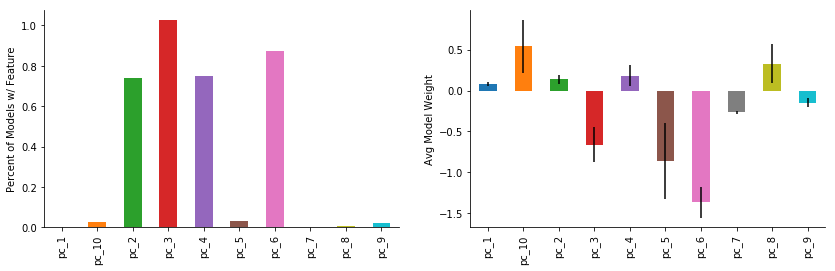

In [81]:
X, y = load_data()

pipe = Pipeline([('pca', PCA()),
                 ('rf_select', SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=5)),
                 ('clf', LogisticRegression(C=1, penalty='l1', class_weight='balanced', solver='liblinear',
                                                max_iter=100, tol=1e-6))])
             
get_feats = lambda pipe: pd.Series(np.squeeze(pipe.steps[-1][1].coef_), 
                                   index=np.array(['pc_' + str(i+1) for i in range(X.shape[1])])[pipe.steps[-2][1].get_support()])

bm, trm, feats = crossval(X, y, pipe, get_feats, ite=100)

print_res(bm, trm)

fsrs = pd.DataFrame.from_dict({v: [np.mean(l), np.std(l), len(l)] for v, l in feats.items()},
                              columns=['mean', 'std', 'count'], orient='index').sort_index()
print(fsrs)

plot_res(feats)

### PCA(10) -> CV: Logit

100%|██████████| 2/2 [00:00<00:00,  3.84it/s]


                   train   test
accuracy           0.804  0.780
balanced_accuracy  0.802  0.774
precision          0.827  0.792
recall             0.825  0.826
roc                0.866  0.761
          mean       std  count
pc_1  0.045866  0.014447     82
pc_2  0.111356  0.024737     82
pc_3 -0.574921  0.052454     82
pc_4  0.154549  0.044202     82
pc_6 -0.728814  0.090846     82


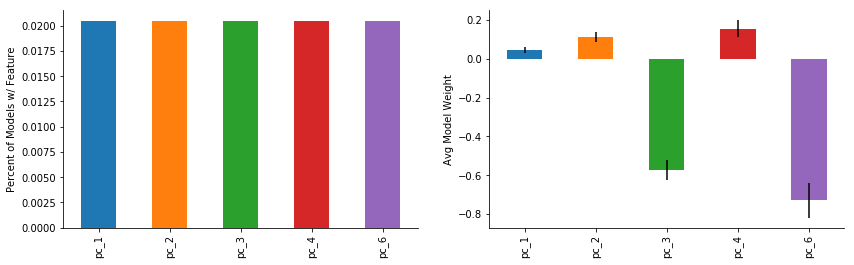

In [83]:
X, y = load_data()
X = pd.DataFrame(PCA().fit_transform(X), columns=['pc_' + str(i+1) for i in range(X.shape[1])])

pipe = Pipeline([('clf', LogisticRegression(C=0.5, penalty='l1', class_weight='balanced', solver='liblinear',
                                            max_iter=100, tol=1e-6))])
             
get_feats = lambda pipe: pd.Series(np.squeeze(pipe.steps[0][1].coef_), index=X.columns)

bm, trm, feats = crossval(X, y, pipe, get_feats, ite=2)

print_res(bm, trm)

fsrs = pd.DataFrame.from_dict({v: [np.mean(l), np.std(l), len(l)] for v, l in feats.items()},
                              columns=['mean', 'std', 'count'], orient='index').sort_index()
print(fsrs)

plot_res(feats)

### CV: PCA(10) / Logit

100%|██████████| 10/10 [00:01<00:00,  6.24it/s]


logit
------------------------
Recall       : 0.783
Precision    : 0.783
Accuracy     : 0.756
Bal. Accuracy: 0.752
ROC AUC.     : 0.725

               mean           std  count
pc_1   6.265955e-02  2.123421e-02    410
pc_10 -9.880119e-02  3.005833e-01    410
pc_11  6.819922e-02  6.453466e-02    410
pc_12 -5.034198e-02  1.005223e-01    410
pc_13  1.109888e-01  8.347907e-02    410
pc_14 -1.009160e-01  1.702078e-01    410
pc_15 -3.985767e-02  1.252703e-01    410
pc_16 -2.552904e-02  6.029560e-02    410
pc_17  1.450059e-01  1.402663e-01    410
pc_18 -1.260625e-01  2.119609e-01    410
pc_19 -1.957092e-02  9.253386e-02    410
pc_2   1.791503e-01  3.839967e-02    410
pc_20 -5.736771e-02  9.035363e-02    410
pc_21 -2.398919e-02  3.643447e-02    410
pc_22 -6.234060e-03  3.865341e-02    410
pc_23 -2.862349e-02  8.820663e-02    410
pc_24 -1.547386e-01  6.500458e-02    410
pc_25 -3.888656e-02  7.810110e-02    410
pc_26 -2.697247e-02  2.052546e-02    410
pc_27  8.875945e-04  2.429914e-02    410
pc

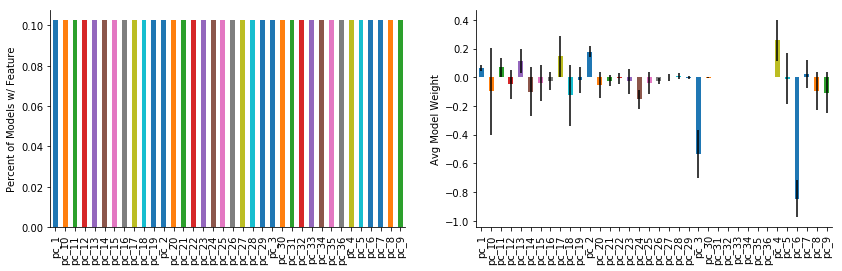

In [502]:
X, y = load_data()

pipe = Pipeline([('pca', PCA()),
                 ('clf', LogisticRegression(C=0.5, penalty='l2', class_weight='balanced', solver='liblinear',
                                                max_iter=100, tol=1e-6))])
             
get_feats = lambda pipe: pd.Series(np.squeeze(pipe.steps[-1][1].coef_), 
                                   index=['pc_' + str(i+1) for i in range(X.shape[1])])

bm, feats = crossval(X, y, pipe, get_feats, ite=10)

print_res(bm)

fsrs = pd.DataFrame.from_dict({v: [np.mean(l), np.std(l), len(l)] for v, l in feats.items()},
                              columns=['mean', 'std', 'count'], orient='index').sort_index()
print(fsrs)

plot_res(feats)

100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


                   train   test
accuracy           0.812  0.780
balanced_accuracy  0.811  0.774
precision          0.839  0.792
recall             0.825  0.826
roc                0.874  0.758
           mean       std  count
pc_1   0.056643  0.021148     41
pc_10  0.391598  0.003979      2
pc_2   0.122494  0.044757     41
pc_3  -0.601441  0.182371     41
pc_4   0.175325  0.107679     40
pc_5  -0.403660  0.414314      3
pc_6  -1.109653  0.196186     40
pc_8   0.299288  0.000000      1


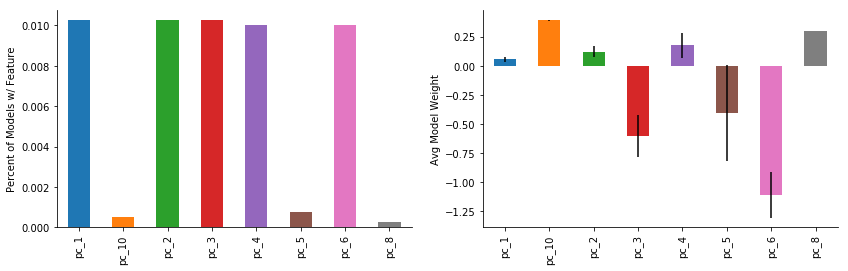

In [30]:
X, y = load_data()

pipe = Pipeline([('pca', PCA()),
                 ('clf', LogisticRegression(C=0.75, penalty='l1', class_weight='balanced', solver='liblinear',
                                                max_iter=100))])
             
get_feats = lambda pipe: pd.Series(np.squeeze(pipe.steps[-1][1].coef_), 
                                   index=['pc_' + str(i+1) for i in range(X.shape[1])])

bm, trm, feats = crossval(X, y, pipe, get_feats, ite=1)

print_res(bm, trm)

fsrs = pd.DataFrame.from_dict({v: [np.mean(l), np.std(l), len(l)] for v, l in feats.items()},
                              columns=['mean', 'std', 'count'], orient='index').sort_index()
print(fsrs)

plot_res(feats)

### CV: PCA(10)/ElasticNet

In [589]:
X, y = load_data()

for ratio in [0, 0.25, 0.5, 0.75, 1]:
    for C in [0.25, 0.5, 1, 1.5]:
#C =1
#ratio = 0.25

        pipe = Pipeline([('pca', PCA(10)),
                         ('clf', LogisticRegression(C=C, penalty='elasticnet', l1_ratio=ratio, 
                                                    class_weight='balanced', solver='saga',
                                                    max_iter=100, tol=1e-6))])

        get_feats = lambda pipe: pd.Series(np.squeeze(pipe.steps[1][1].coef_), 
                                           index=['pc_' + str(i+1) for i in range(10)])

        bm, feats = crossval(X, y, pipe, get_feats, ite=10, verbose=False)

        model = '\nElasticNet - C: {}, Ratio: {}'.format(C, ratio)

        print_res(bm, model)


#fsrs = pd.DataFrame.from_dict({v: [np.mean(l), np.std(l), len(l)] for v, l in feats.items()},
#                              columns=['mean', 'std', 'count'], orient='index').sort_index()
#print(fsrs)

#plot_res(feats)


ElasticNet - C: 0.25, Ratio: 0
------------------------
Recall       : 0.826
Precision    : 0.792
Accuracy     : 0.780
Bal. Accuracy: 0.774
ROC AUC.     : 0.742


ElasticNet - C: 0.5, Ratio: 0
------------------------
Recall       : 0.826
Precision    : 0.792
Accuracy     : 0.780
Bal. Accuracy: 0.774
ROC AUC.     : 0.739


ElasticNet - C: 1, Ratio: 0
------------------------
Recall       : 0.826
Precision    : 0.792
Accuracy     : 0.780
Bal. Accuracy: 0.774
ROC AUC.     : 0.739


ElasticNet - C: 1.5, Ratio: 0
------------------------
Recall       : 0.783
Precision    : 0.783
Accuracy     : 0.756
Bal. Accuracy: 0.752
ROC AUC.     : 0.737


ElasticNet - C: 0.25, Ratio: 0.25
------------------------
Recall       : 0.783
Precision    : 0.783
Accuracy     : 0.756
Bal. Accuracy: 0.752
ROC AUC.     : 0.744


ElasticNet - C: 0.5, Ratio: 0.25
------------------------
Recall       : 0.826
Precision    : 0.792
Accuracy     : 0.780
Bal. Accuracy: 0.774
ROC AUC.     : 0.744


ElasticNet - C: 1, Ra

### CV: Logit

100%|██████████| 100/100 [00:25<00:00,  3.94it/s]


                   train   test
accuracy           0.715  0.683
balanced_accuracy  0.717  0.681
precision          0.770  0.727
recall             0.700  0.696
roc                0.819  0.734
             mean       std  count
theta_0 -0.249193  0.141254   3800
theta_2 -0.494703  0.134416   4000
theta_3 -0.024718  0.000008    100
theta_5 -0.074228  0.078248   2300


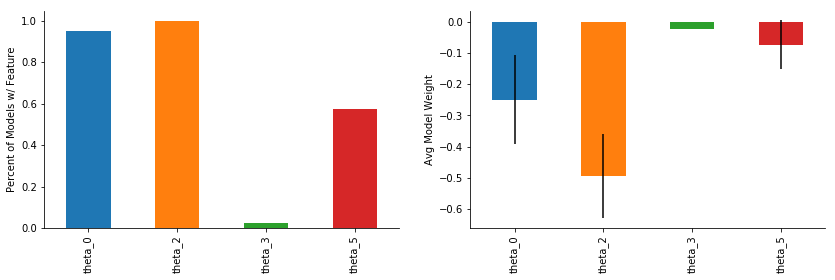

In [84]:
X, y = load_data()

pipe = Pipeline([('clf', LogisticRegression(C=0.25, penalty='l1', class_weight='balanced', solver='liblinear',
                                                max_iter=100, tol=1e-6))])
             
get_feats = lambda pipe: pd.Series(np.squeeze(pipe.steps[0][1].coef_), 
                                   index=X.columns)

bm, trm, feats = crossval(X, y, pipe, get_feats, ite=100)

print_res(bm, trm)

fsrs = pd.DataFrame.from_dict({v: [np.mean(l), np.std(l), len(l)] for v, l in feats.items()},
                              columns=['mean', 'std', 'count'], orient='index').sort_index()
print(fsrs)

plot_res(feats)

### Logit L2

100%|██████████| 100/100 [00:25<00:00,  3.88it/s]


                   train   test
accuracy           0.787  0.780
balanced_accuracy  0.781  0.774
precision          0.801  0.792
recall             0.826  0.826
roc                0.879  0.732
              mean       std  count
alpha_0  -0.148193  0.021187   4100
alpha_1   0.197100  0.018497   4100
alpha_2  -0.092271  0.025423   4100
alpha_3  -0.019598  0.018401   4100
alpha_4   0.127261  0.021584   4100
alpha_5   0.183548  0.023983   4100
beta_0   -0.025723  0.026295   4100
beta_1    0.229325  0.021878   4100
beta_2    0.072391  0.018779   4100
beta_3   -0.037935  0.027277   4100
beta_4    0.127827  0.016566   4100
beta_5    0.145350  0.017065   4100
delta_0   0.239275  0.019536   4100
delta_1  -0.148510  0.017240   4100
delta_2   0.137320  0.017066   4100
delta_3   0.185124  0.018203   4100
delta_4  -0.057282  0.016002   4100
delta_5   0.007874  0.020046   4100
gammaH_0 -0.107574  0.010934   4100
gammaH_1 -0.041783  0.011724   4100
gammaH_2 -0.117511  0.022900   4100
gammaH_3 -0.0370

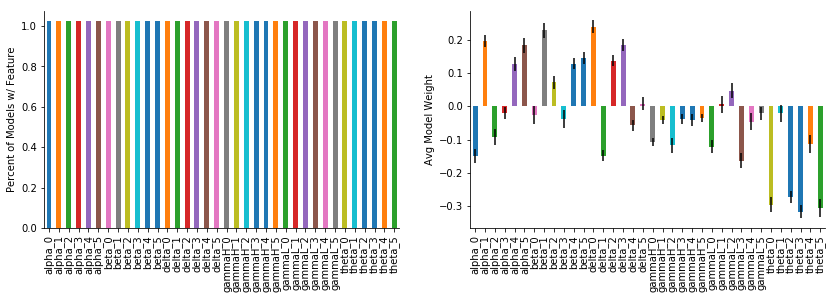

In [86]:
X, y = load_data()

pipe = Pipeline([('clf', LogisticRegression(C=0.25, penalty='l2', class_weight='balanced', solver='liblinear',
                                                max_iter=100, tol=1e-6))])
             
get_feats = lambda pipe: pd.Series(np.squeeze(pipe.steps[0][1].coef_), 
                                   index=X.columns)

bm, trm, feats = crossval(X, y, pipe, get_feats, ite=100)

print_res(bm, trm)

fsrs = pd.DataFrame.from_dict({v: [np.mean(l), np.std(l), len(l)] for v, l in feats.items()},
                              columns=['mean', 'std', 'count'], orient='index').sort_index()
print(fsrs)

plot_res(feats)

### ElasticNet w/ anova

100%|██████████| 10/10 [00:01<00:00,  5.38it/s]


logit
------------------------
Recall       : 0.696
Precision    : 0.727
Accuracy     : 0.683
Bal. Accuracy: 0.681
ROC AUC.     : 0.705

             mean       std  count
delta_0  0.125348  0.102010     50
delta_2 -0.000815  0.000301      9
delta_5 -0.089423  0.065705    380
theta_0 -0.441012  0.111445    410
theta_1  0.233639  0.088127    402
theta_2 -0.678336  0.116755    410
theta_3 -0.157162  0.100015    398
theta_5 -0.373279  0.074940    400


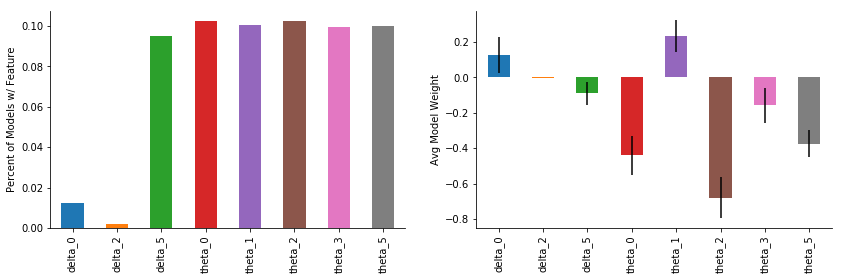

In [551]:
from sklearn.feature_selection import f_classif, SelectKBest

X, y = load_data()

pipe = Pipeline([('f_select', SelectKBest(f_classif, k=10)),
                 ('clf', LogisticRegression(C=1, l1_ratio=0.5, 
                                            penalty='elasticnet', class_weight='balanced', solver='saga',
                                            max_iter=100, tol=1e-6))])
             
get_feats = lambda pipe: pd.Series(np.squeeze(pipe.steps[1][1].coef_), 
                                   index=X.columns[pipe.steps[0][1].get_support()])

bm, feats = crossval(X, y, pipe, get_feats, ite=10)

print_res(bm)

fsrs = pd.DataFrame.from_dict({v: [np.mean(l), np.std(l), len(l)] for v, l in feats.items()},
                              columns=['mean', 'std', 'count'], orient='index').sort_index()
print(fsrs)

plot_res(feats)

### ElasticNet

                   train   test
accuracy           0.793  0.756
balanced_accuracy  0.788  0.752
precision          0.807  0.783
recall             0.830  0.783
roc                0.890  0.717
              mean       std  count
alpha_0  -0.285122  0.049756    410
alpha_1   0.299980  0.040539    410
alpha_2  -0.117247  0.040968    400
alpha_3  -0.024581  0.015507     55
alpha_4   0.112266  0.051085    410
alpha_5   0.271074  0.060593    410
beta_0   -0.048273  0.044760     60
beta_1    0.408381  0.054892    410
beta_2    0.036900  0.033681    299
beta_3   -0.032243  0.040453    199
beta_4    0.137783  0.040663    410
beta_5    0.191603  0.042469    410
delta_0   0.413241  0.050128    410
delta_1  -0.282628  0.041910    410
delta_2   0.127459  0.037697    400
delta_3   0.276579  0.049861    410
delta_4  -0.035659  0.031639    301
delta_5  -0.008648  0.016462     30
gammaH_0 -0.159730  0.030899    410
gammaH_1 -0.016217  0.022385     50
gammaH_2 -0.196851  0.035281    400
gammaH_3 -0.0505

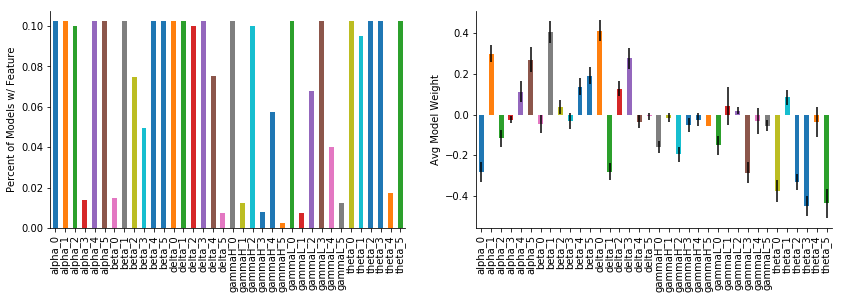

In [87]:
X, y = load_data()

#for ratio in [0, 0.25, 0.5, 0.75, 1]:
#    for C in [0.25, 0.5, 1, 1.5]:
C =1
ratio = 0.25

pipe = Pipeline([('clf', LogisticRegression(C=C, penalty='elasticnet', l1_ratio=ratio, 
                                            class_weight='balanced', solver='saga',
                                            max_iter=100, tol=1e-6))])

get_feats = lambda pipe: pd.Series(np.squeeze(pipe.steps[0][1].coef_), 
                                   index=X.columns)

bm, trm, feats = crossval(X, y, pipe, get_feats, ite=10, verbose=False)

model = '\nElasticNet - C: {}, Ratio: {}'.format(C, ratio)

print_res(bm, trm, model)


fsrs = pd.DataFrame.from_dict({v: [np.mean(l), np.std(l), len(l)] for v, l in feats.items()},
                              columns=['mean', 'std', 'count'], orient='index').sort_index()
print(fsrs)

plot_res(feats)

### CV: RF

100%|██████████| 10/10 [00:33<00:00,  3.31s/it]


                   train   test
accuracy             1.0  0.634
balanced_accuracy    1.0  0.620
precision            1.0  0.654
recall               1.0  0.739
roc                  1.0  0.680
              mean       std  count
alpha_0   0.019279  0.005729    410
alpha_1   0.015316  0.005127    410
alpha_2   0.016507  0.005083    410
alpha_3   0.020038  0.006226    410
alpha_4   0.022314  0.006291    410
alpha_5   0.018217  0.005238    410
beta_0    0.016015  0.004763    410
beta_1    0.021681  0.006165    410
beta_2    0.015119  0.004578    410
beta_3    0.016824  0.005117    410
beta_4    0.026507  0.006820    410
beta_5    0.021286  0.006665    410
delta_0   0.023345  0.007192    410
delta_1   0.019188  0.005872    410
delta_2   0.020155  0.006116    410
delta_3   0.026846  0.007695    410
delta_4   0.019182  0.005836    410
delta_5   0.021758  0.006372    410
gammaH_0  0.023433  0.006015    410
gammaH_1  0.018199  0.005294    410
gammaH_2  0.019061  0.005405    410
gammaH_3  0.0195

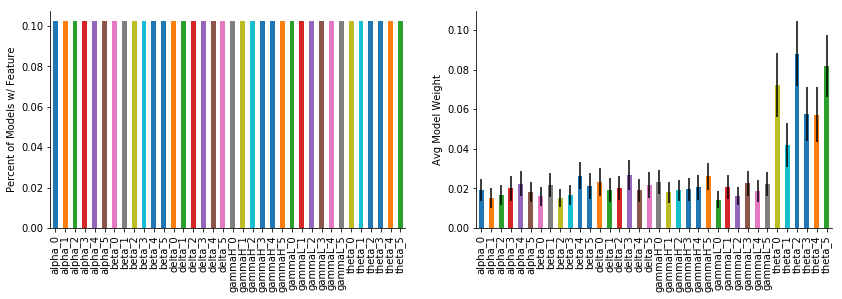

In [88]:
X, y = load_data()

pipe = Pipeline([('clf', RandomForestClassifier(n_estimators=100, max_features=5))])
             
get_feats = lambda pipe: pd.Series(np.squeeze(pipe.steps[0][1].feature_importances_), 
                                   index=X.columns)

bm, trm, feats = crossval(X, y, pipe, get_feats, ite=10)

print_res(bm, trm)

fsrs = pd.DataFrame.from_dict({v: [np.mean(l), np.std(l), len(l)] for v, l in feats.items()},
                              columns=['mean', 'std', 'count'], orient='index').sort_index()
print(fsrs)

plot_res(feats)

### CV: SVM (rbf)

In [494]:
X, y = load_data()

pipe = Pipeline([('clf', SVC(C=1, kernel='rbf', class_weight='balanced', probability=True))])
             
get_feats = lambda pipe: pd.Series({'a': 1, 'b': 2})

bm, feats = crossval(X, y, pipe, get_feats, ite=100)

print_res(bm)

fsrs = pd.DataFrame.from_dict({v: [np.mean(l), np.std(l), len(l)] for v, l in feats.items()},
                              columns=['mean', 'std', 'count'], orient='index').sort_index()
print(fsrs)

#plot_res(feats)

100%|██████████| 100/100 [00:13<00:00,  7.24it/s]

logit
------------------------
Recall       : 0.739
Precision    : 0.630
Accuracy     : 0.610
Bal. Accuracy: 0.592
ROC AUC.     : 0.415

   mean  std  count
a   1.0  0.0   4100
b   2.0  0.0   4100


### CV: SVM (linear)

In [563]:
X, y = load_data()

for C in [0.25, 0.5, 0.75, 1.0, 1.5]:
    
    pipe = Pipeline([('clf', SVC(C=C, kernel='linear', class_weight='balanced', probability=True))])

    get_feats = lambda pipe: pd.Series({'a': 1, 'b': 2})

    bm, feats = crossval(X, y, pipe, get_feats, ite=10)

    print_res(bm, model='Linear SVM ({})'.format(C))

#fsrs = pd.DataFrame.from_dict({v: [np.mean(l), np.std(l), len(l)] for v, l in feats.items()},
#                              columns=['mean', 'std', 'count'], orient='index').sort_index()
#print(fsrs)

#plot_res(feats)

  0%|          | 0/10 [00:00<?, ?it/s]

Linear SVM (0.25)
------------------------
Recall       : 0.696
Precision    : 0.727
Accuracy     : 0.683
Bal. Accuracy: 0.681
ROC AUC.     : 0.655



  0%|          | 0/10 [00:00<?, ?it/s]

Linear SVM (0.5)
------------------------
Recall       : 0.739
Precision    : 0.739
Accuracy     : 0.707
Bal. Accuracy: 0.703
ROC AUC.     : 0.681



  0%|          | 0/10 [00:00<?, ?it/s]

Linear SVM (0.75)
------------------------
Recall       : 0.739
Precision    : 0.739
Accuracy     : 0.707
Bal. Accuracy: 0.703
ROC AUC.     : 0.688



  0%|          | 0/10 [00:00<?, ?it/s]

Linear SVM (1.0)
------------------------
Recall       : 0.739
Precision    : 0.739
Accuracy     : 0.707
Bal. Accuracy: 0.703
ROC AUC.     : 0.699



100%|██████████| 10/10 [00:02<00:00,  3.41it/s]

Linear SVM (1.5)
------------------------
Recall       : 0.696
Precision    : 0.727
Accuracy     : 0.683
Bal. Accuracy: 0.681
ROC AUC.     : 0.606



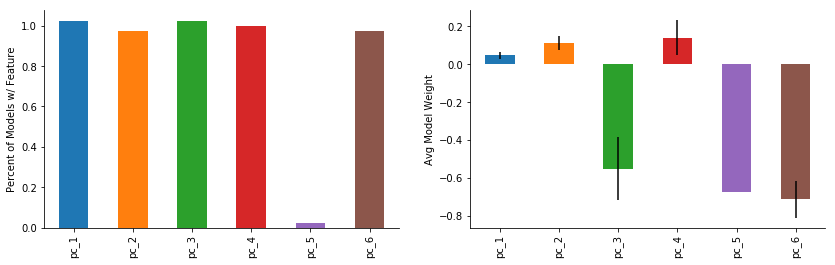

In [394]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

fsrs['count'].apply(lambda v: v/4000).plot(kind='bar', ax=axs[0]);
axs[0].set_ylabel('Percent of Models w/ Feature')
fsrs['mean'].plot(kind='bar', yerr=fsrs['std'], ax=axs[1])
axs[1].set_ylabel('Avg Model Weight')

sns.despine()

In [112]:
X, y = load_data()
X = pd.DataFrame(PCA().fit_transform(X))

preds = list()
probs = list()
model = 'logit'

for train_idx, test_idx in LeaveOneOut().split(X):

    pipe = Pipeline([('rf_select', SelectFromModel(RandomForestClassifier(n_estimators=200), max_features=10)), 
                     ('clf', LogisticRegression(C=1, penalty='l1', class_weight='balanced', solver='liblinear',
                                                    max_iter=5000, tol=1e-6))])
    pipe.fit(X.iloc[train_idx], y.iloc[train_idx])
    pred = pipe.predict(X.iloc[test_idx])[0]
    proba = pipe.predict_proba(X.iloc[test_idx])[0][1]
    preds.append(pred)
    probs.append(proba)

bm = pd.DataFrame(list(zip(preds, probs, y.values.tolist())), columns=['pred', 'proba', 'actual'])

rs = recall_score(bm['actual'], bm['pred'])
ps = precision_score(bm['actual'], bm['pred'])
acc = accuracy_score(bm['actual'], bm['pred'])
bacc = balanced_accuracy_score(bm['actual'], bm['pred'])
roc = roc_auc_score(bm['actual'], bm['proba'])

print(model)
print('------------------------')
print('Recall       : {:1.3f}'.format(rs))
print('Precision    : {:1.3f}'.format(ps))
print('Accuracy     : {:1.3f}'.format(acc))
print('Bal. Accuracy: {:1.3f}'.format(bacc))
print('ROC AUC.     : {:1.3f}\n'.format(roc))

logit
------------------------
Recall       : 0.870
Precision    : 0.833
Accuracy     : 0.829
Bal. Accuracy: 0.824
ROC AUC.     : 0.790



In [158]:
X, y = load_data()
X = pd.DataFrame(PCA().fit_transform(X))

preds = list()
probs = list()
model = 'logit'
for train_idx, test_idx in LeaveOneOut().split(X):

    pipe = Pipeline([('clf', LogisticRegression(C=0.50, penalty='l1', class_weight='balanced', solver='liblinear',
                                                    max_iter=5000, tol=1e-6))])
    pipe.fit(X.iloc[train_idx], y.iloc[train_idx])
    pred = pipe.predict(X.iloc[test_idx])[0]
    proba = pipe.predict_proba(X.iloc[test_idx])[0][1]
    preds.append(pred)
    probs.append(proba)

bm = pd.DataFrame(list(zip(preds, probs, y.values.tolist())), columns=['pred', 'proba', 'actual'])

rs = recall_score(bm['actual'], bm['pred'])
ps = precision_score(bm['actual'], bm['pred'])
acc = accuracy_score(bm['actual'], bm['pred'])
bacc = balanced_accuracy_score(bm['actual'], bm['pred'])
roc = roc_auc_score(bm['actual'], bm['proba'])

print(model)
print('------------------------')
print('Recall       : {:1.3f}'.format(rs))
print('Precision    : {:1.3f}'.format(ps))
print('Accuracy     : {:1.3f}'.format(acc))
print('Bal. Accuracy: {:1.3f}'.format(bacc))
print('ROC AUC.     : {:1.3f}\n'.format(roc))

pipe.steps[0][1].coef_

logit
------------------------
Recall       : 0.826
Precision    : 0.792
Accuracy     : 0.780
Bal. Accuracy: 0.774
ROC AUC.     : 0.761



array([[ 0.04291451,  0.13707589, -0.51387542,  0.19409212,  0.        ,
        -0.76522394,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ]])

In [164]:
X, y = load_data()

preds = list()
probs = list()
model = 'logit'

for train_idx, test_idx in LeaveOneOut().split(X):

    pipe = Pipeline([('pca', PCA(n_components=10)), 
                     ('clf', LogisticRegression(C=0.5, penalty='l1', class_weight='balanced', solver='liblinear',
                                                    max_iter=5000, tol=1e-6))])
    pipe.fit(X.iloc[train_idx], y.iloc[train_idx])
    pred = pipe.predict(X.iloc[test_idx])[0]
    proba = pipe.predict_proba(X.iloc[test_idx])[0][1]
    preds.append(pred)
    probs.append(proba)

bm = pd.DataFrame(list(zip(preds, probs, y.values.tolist())), columns=['pred', 'proba', 'actual'])

rs = recall_score(bm['actual'], bm['pred'])
ps = precision_score(bm['actual'], bm['pred'])
acc = accuracy_score(bm['actual'], bm['pred'])
bacc = balanced_accuracy_score(bm['actual'], bm['pred'])
roc = roc_auc_score(bm['actual'], bm['proba'])

print(model)
print('------------------------')
print('Recall       : {:1.3f}'.format(rs))
print('Precision    : {:1.3f}'.format(ps))
print('Accuracy     : {:1.3f}'.format(acc))
print('Bal. Accuracy: {:1.3f}'.format(bacc))
print('ROC AUC.     : {:1.3f}\n'.format(roc))

logit
------------------------
Recall       : 0.826
Precision    : 0.792
Accuracy     : 0.780
Bal. Accuracy: 0.774
ROC AUC.     : 0.758



In [170]:
X, y = load_data()
X = pd.DataFrame(PCA(n_components=10).fit_transform(X))

preds = list()
probs = list()
model = 'logit'
for train_idx, test_idx in LeaveOneOut().split(X):

    pipe = Pipeline([('clf', LogisticRegression(C=0.5, penalty='l1', class_weight='balanced', solver='liblinear',
                                                    max_iter=5000, tol=1e-6))])
    pipe.fit(X.iloc[train_idx], y.iloc[train_idx])
    pred = pipe.predict(X.iloc[test_idx])[0]
    proba = pipe.predict_proba(X.iloc[test_idx])[0][1]
    preds.append(pred)
    probs.append(proba)

bm = pd.DataFrame(list(zip(preds, probs, y.values.tolist())), columns=['pred', 'proba', 'actual'])

rs = recall_score(bm['actual'], bm['pred'])
ps = precision_score(bm['actual'], bm['pred'])
acc = accuracy_score(bm['actual'], bm['pred'])
bacc = balanced_accuracy_score(bm['actual'], bm['pred'])
roc = roc_auc_score(bm['actual'], bm['proba'])

print(model)
print('------------------------')
print('Recall       : {:1.3f}'.format(rs))
print('Precision    : {:1.3f}'.format(ps))
print('Accuracy     : {:1.3f}'.format(acc))
print('Bal. Accuracy: {:1.3f}'.format(bacc))
print('ROC AUC.     : {:1.3f}\n'.format(roc))

logit
------------------------
Recall       : 0.826
Precision    : 0.792
Accuracy     : 0.780
Bal. Accuracy: 0.774
ROC AUC.     : 0.761



1. pca10, np.nan: 0.752
2. pca10, no nan: 0.824
2. pca, np.nan: 0.824
3. pca, no nan: 0.824

In [199]:
X, y = load_data()
X = pd.DataFrame(PCA().fit_transform(X))

preds = list()
probs = list()
model = 'logit'
for train_idx, test_idx in LeaveOneOut().split(X):

    pipe = Pipeline([('rf_select', SelectFromModel(RandomForestClassifier(n_estimators=200), max_features=5)), 
                     ('clf', LogisticRegression(C=1, penalty='l1', class_weight='balanced', solver='liblinear',
                                                    max_iter=5000, tol=1e-6))])
    pipe.fit(X.iloc[train_idx], y.iloc[train_idx])
    pred = pipe.predict(X.iloc[test_idx])[0]
    proba = pipe.predict_proba(X.iloc[test_idx])[0][1]
    preds.append(pred)
    probs.append(proba)

bm = pd.DataFrame(list(zip(preds, probs, y.values.tolist())), columns=['pred', 'proba', 'actual'])

rs = recall_score(bm['actual'], bm['pred'])
ps = precision_score(bm['actual'], bm['pred'])
acc = accuracy_score(bm['actual'], bm['pred'])
bacc = balanced_accuracy_score(bm['actual'], bm['pred'])
roc = roc_auc_score(bm['actual'], bm['proba'])

print(model)
print('------------------------')
print('Recall       : {:1.3f}'.format(rs))
print('Precision    : {:1.3f}'.format(ps))
print('Accuracy     : {:1.3f}'.format(acc))
print('Bal. Accuracy: {:1.3f}'.format(bacc))
print('ROC AUC.     : {:1.3f}\n'.format(roc))

logit
------------------------
Recall       : 0.870
Precision    : 0.800
Accuracy     : 0.805
Bal. Accuracy: 0.796
ROC AUC.     : 0.771



In [233]:
LeaveOneOut.split?

In [239]:
X, y = load_data(zscore=False)

preds = list()
probs = list()
model = 'logit'
indices = list()

for train_idx, test_idx in LeaveOneOut().split(X):
    indices.append(test_idx)

    pipe = Pipeline([('zscore', StandardScaler()),
                     ('pca', PCA()),
                     ('rf_select', SelectFromModel(RandomForestClassifier(n_estimators=200), max_features=10)),
                     ('clf', LogisticRegression(C=0.5, penalty='l1', class_weight='balanced', solver='liblinear',
                                                    max_iter=5000, tol=1e-6))])
    pipe.fit(X.iloc[train_idx], y.iloc[train_idx])
    pred = pipe.predict(X.iloc[test_idx])[0]
    proba = pipe.predict_proba(X.iloc[test_idx])[0][1]
    preds.append(pred)
    probs.append(proba)

bm = pd.DataFrame(list(zip(preds, probs, y.values.tolist())), columns=['pred', 'proba', 'actual'])

rs = recall_score(bm['actual'], bm['pred'])
ps = precision_score(bm['actual'], bm['pred'])
acc = accuracy_score(bm['actual'], bm['pred'])
bacc = balanced_accuracy_score(bm['actual'], bm['pred'])
roc = roc_auc_score(bm['actual'], bm['proba'])

print(model)
print('------------------------')
print('Recall       : {:1.3f}'.format(rs))
print('Precision    : {:1.3f}'.format(ps))
print('Accuracy     : {:1.3f}'.format(acc))
print('Bal. Accuracy: {:1.3f}'.format(bacc))
print('ROC AUC.     : {:1.3f}\n'.format(roc))

pipe.steps[3][1].coef_

logit
------------------------
Recall       : 0.826
Precision    : 0.760
Accuracy     : 0.756
Bal. Accuracy: 0.746
ROC AUC.     : 0.725



array([[ 0.24460432, -0.49228463,  0.        , -0.75391973,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

   est__C  mean_train_score  mean_test_score
0    0.10          0.713345         0.658537
1    0.15          0.736508         0.634146
2    0.20          0.742619         0.634146
3    0.25          0.735711         0.658537
4    0.50          0.796050         0.756098
5    1.00          0.805452         0.780488
6    1.50          0.803220         0.780488
7    2.00          0.801865         0.756098

pca
----------
PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

est
----------
LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)



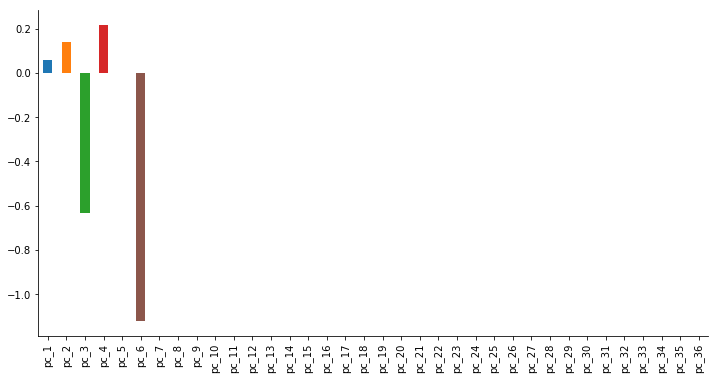

In [92]:
metrics = 'balanced_accuracy'
params = {'C':[0.1, 0.15, 0.2, 0.25, 0.5, 1.0, 1.5, 2.0],
          'class_weight': ['balanced'],
          'penalty': ['l1'],
          'solver': ['saga'],
          'max_iter': [100]}

logit = Logit(params, metrics, pca=True)
logit.fit(X, y)
logit.quick_results()

fig, ax = plt.subplots(figsize=(12, 6))

feats = logit.feat_importances()

feats.plot(kind='bar', ax=ax)

sns.despine();

      C  mean_train_score  mean_test_score
0  0.10          0.707255         0.682927
1  0.15          0.738724         0.634146
2  0.20          0.744101         0.634146
3  0.25          0.738664         0.658537
4  0.50          0.796285         0.756098
5  1.00          0.811298         0.780488
6  1.50          0.806914         0.780488
7  2.00          0.804615         0.756098

est
----------
LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)



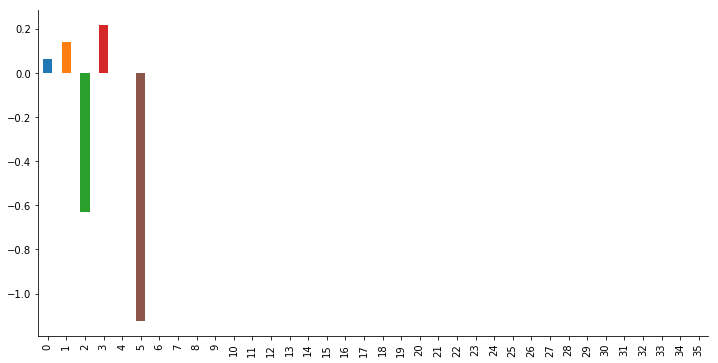

In [59]:
metrics = 'balanced_accuracy'
params = {'C':[0.1, 0.15, 0.2, 0.25, 0.5, 1.0, 1.5, 2.0],
          'class_weight': ['balanced'],
          'penalty': ['l1'],
          'solver': ['saga'],
          'max_iter': [100]}

logit = Logit(params, metrics, pca=False)
logit.fit(Xpca, y)
logit.quick_results()

fig, ax = plt.subplots(figsize=(12, 6))

feats = logit.feat_importances()

feats.plot(kind='bar', ax=ax)

sns.despine();

   mean_train_score  mean_test_score
0          0.720859         0.682927

est
----------
LogisticRegression(C=0.15, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)



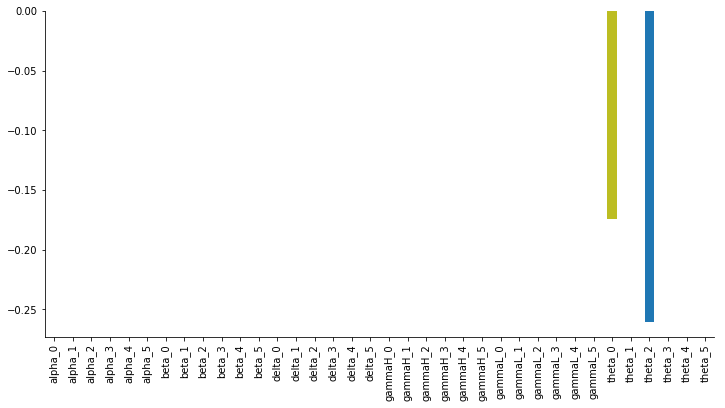

In [57]:
metrics = 'balanced_accuracy'
params = {'C': [0.15],
          'class_weight': ['balanced'],
          'penalty': ['l1'],
          'solver': ['saga'],
          'max_iter': [100]}

logit = Logit(params, metrics, pca=False)
logit.fit(X, y)
logit.quick_results()

fig, ax = plt.subplots(figsize=(12, 6))

feats = logit.feat_importances()

feats.plot(kind='bar', ax=ax)

sns.despine();

   mean_train_score  mean_test_score
0          0.743174         0.634146

pca
----------
PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

est
----------
LogisticRegression(C=0.2, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='saga', tol=0.0001, verbose=0, warm_start=False)



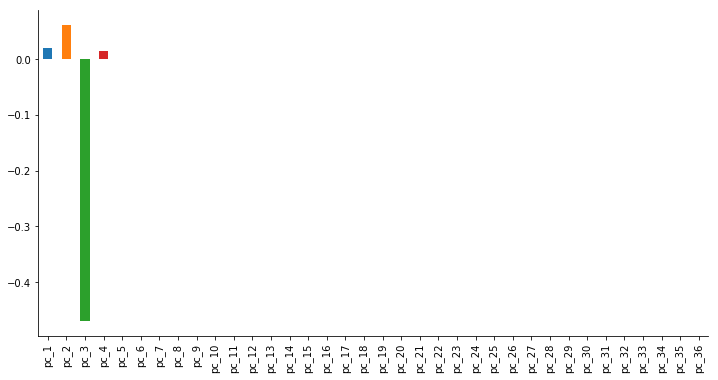

In [76]:
metrics = 'balanced_accuracy'
params = {'C': [0.2],# np.arange(0.5, 1.01, 0.1),
          'class_weight': ['balanced'],
          'penalty': ['l1'],
          'solver': ['saga'],
          'max_iter': [100]}

logit = Logit(params, metrics, pca=True)
logit.fit(X, y)
logit.quick_results()

fig, ax = plt.subplots(figsize=(12, 6))

feats = logit.feat_importances()

feats.plot(kind='bar', ax=ax)

sns.despine();

   mean_train_score  mean_test_score
0          0.736429         0.658537

pca
----------
PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

est
----------
LogisticRegression(C=0.25, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='saga', tol=0.0001, verbose=0, warm_start=False)



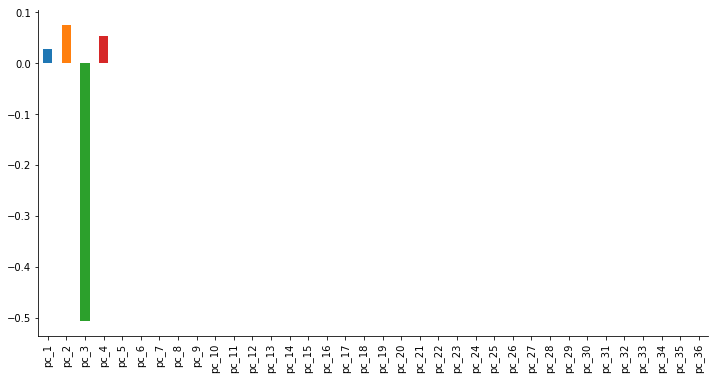

In [77]:
metrics = 'balanced_accuracy'
params = {'C': [0.25],# np.arange(0.5, 1.01, 0.1),
          'class_weight': ['balanced'],
          'penalty': ['l1'],
          'solver': ['saga'],
          'max_iter': [100]}

logit = Logit(params, metrics, pca=True)
logit.fit(X, y)
logit.quick_results()

fig, ax = plt.subplots(figsize=(12, 6))

feats = logit.feat_importances()

feats.plot(kind='bar', ax=ax)

sns.despine();

   mean_train_score  mean_test_score
0          0.799409         0.756098

pca
----------
PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

est
----------
LogisticRegression(C=0.5, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='saga', tol=0.0001, verbose=0, warm_start=False)



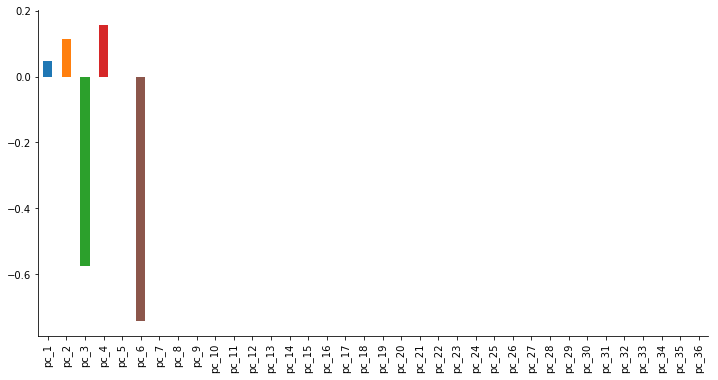

In [78]:
metrics = 'balanced_accuracy'
params = {'C': [0.5],# np.arange(0.5, 1.01, 0.1),
          'class_weight': ['balanced'],
          'penalty': ['l1'],
          'solver': ['saga'],
          'max_iter': [100]}

logit = Logit(params, metrics, pca=True)
logit.fit(X, y)
logit.quick_results()

fig, ax = plt.subplots(figsize=(12, 6))

feats = logit.feat_importances()

feats.plot(kind='bar', ax=ax)

sns.despine();

   mean_train_score  mean_test_score
0          0.819241         0.780488

pca
----------
PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

est
----------
LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='saga', tol=0.0001, verbose=0, warm_start=False)



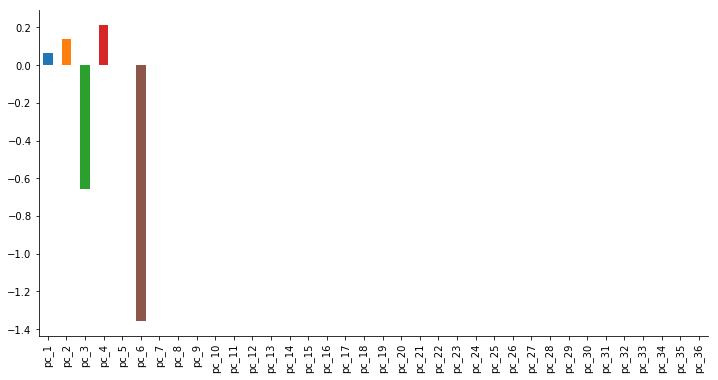

In [79]:
metrics = 'balanced_accuracy'
params = {'C': [1],# np.arange(0.5, 1.01, 0.1),
          'class_weight': ['balanced'],
          'penalty': ['l1'],
          'solver': ['saga'],
          'max_iter': [100]}

logit = Logit(params, metrics, pca=True)
logit.fit(X, y)
logit.quick_results()

fig, ax = plt.subplots(figsize=(12, 6))

feats = logit.feat_importances()

feats.plot(kind='bar', ax=ax)

sns.despine();

   mean_train_score  mean_test_score
0          0.813051         0.756098

pca
----------
PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

est
----------
LogisticRegression(C=1.5, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='saga', tol=0.0001, verbose=0, warm_start=False)



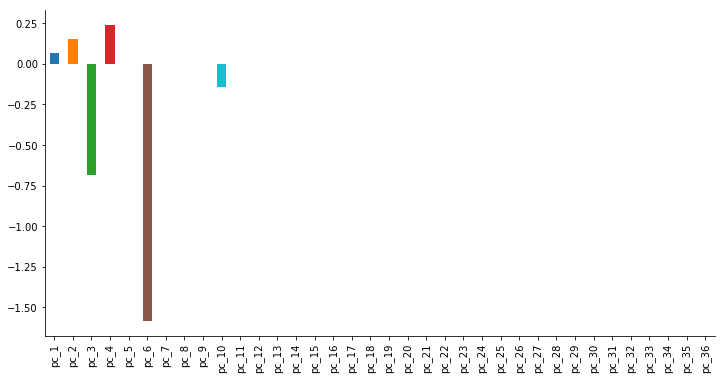

In [80]:
metrics = 'balanced_accuracy'
params = {'C': [1.5],# np.arange(0.5, 1.01, 0.1),
          'class_weight': ['balanced'],
          'penalty': ['l1'],
          'solver': ['saga'],
          'max_iter': [100]}

logit = Logit(params, metrics, pca=True)
logit.fit(X, y)
logit.quick_results()

fig, ax = plt.subplots(figsize=(12, 6))

feats = logit.feat_importances()

feats.plot(kind='bar', ax=ax)

sns.despine();

   mean_train_score  mean_test_score
0          0.813254         0.756098

pca
----------
PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

est
----------
LogisticRegression(C=2, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='saga', tol=0.0001, verbose=0, warm_start=False)



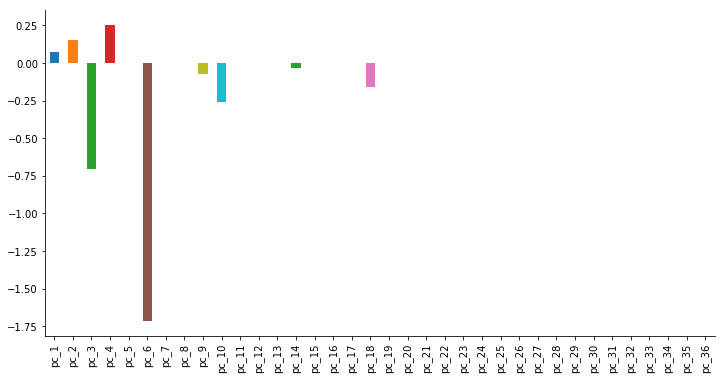

In [81]:
metrics = 'balanced_accuracy'
params = {'C': [2],# np.arange(0.5, 1.01, 0.1),
          'class_weight': ['balanced'],
          'penalty': ['l1'],
          'solver': ['saga'],
          'max_iter': [100]}

logit = Logit(params, metrics, pca=True)
logit.fit(X, y)
logit.quick_results()

fig, ax = plt.subplots(figsize=(12, 6))

feats = logit.feat_importances()

feats.plot(kind='bar', ax=ax)

sns.despine();

In [82]:
res = pd.DataFrame(
    {'C': [0.15, 0.2, 0.25, 0.5, 1.0, 1.5, 2.0],
     'n_feats': [3, 4, 4, 5, 5, 5, 9],
     'bac': [0.634146, 0.634146, 0.658537, 0.756098, 0.780488, 0.756098, 0.756098]}
)

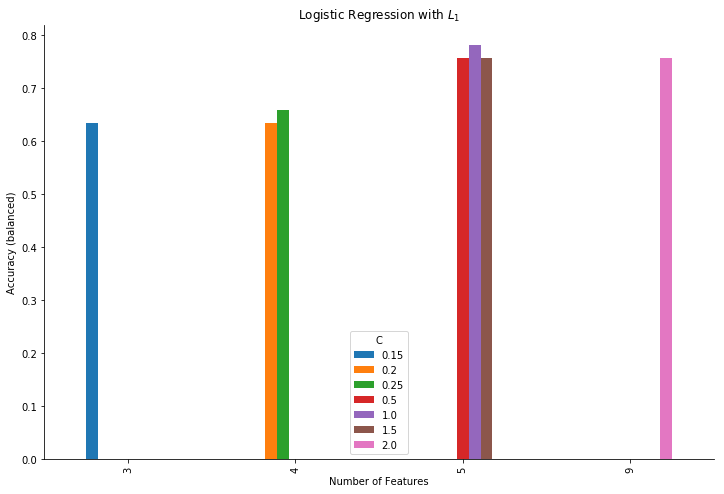

In [102]:
fig, ax = plt.subplots(figsize=(12, 8))

res.pivot(index='n_feats', columns='C', values='bac').plot(kind='bar', ax=ax);

ax.set_xlabel('Number of Features')
ax.set_ylabel('Accuracy (balanced)')
ax.set_title('Logistic Regression with $L_1$')

sns.despine()

## ElasticNet

    alpha  l1_ratio  mean_train_score  mean_test_score
0     0.1      0.00          0.763150         0.682927
1     0.1      0.25          0.723228         0.707317
2     0.1      0.50          0.716646         0.682927
3     0.1      0.75          0.719700         0.658537
4     0.1      1.00          0.706342         0.658537
5     0.3      0.00          0.732968         0.731707
6     0.3      0.25          0.698530         0.658537
7     0.3      0.50          0.685150         0.658537
8     0.3      0.75          0.538506         0.560976
9     0.3      1.00          0.506282         0.536585
10    0.5      0.00          0.729259         0.634146
11    0.5      0.25          0.679652         0.634146
12    0.5      0.50          0.502072         0.560976
13    0.5      0.75          0.500000         0.560976
14    0.5      1.00          0.500000         0.560976
15    1.0      0.00          0.723823         0.634146
16    1.0      0.25          0.503795         0.463415
17    1.0 

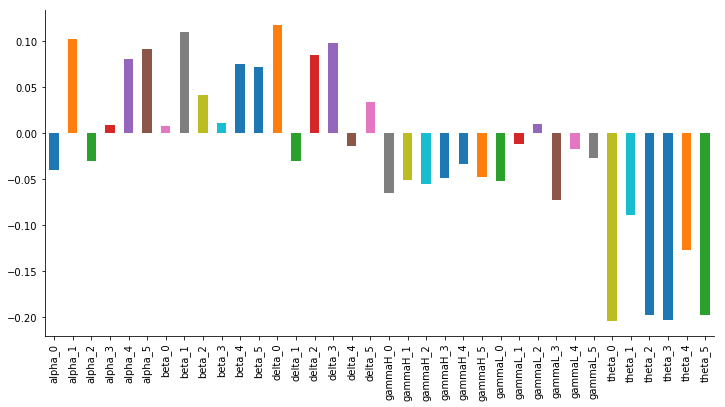

In [19]:
metrics = 'balanced_accuracy'
params = {'alpha':[0.1, 0.3, 0.5, 1.0, 1.5, 2.0],
          'l1_ratio': [0, 0.25, 0.5, 0.75, 1],
          'penalty': ['elasticnet'],
          'loss': ['log'],
          'max_iter': [100]}

sgd = SGDC(params, metrics)
sgd.fit(X, y)
res = sgd.quick_results(df=True)


fig, ax = plt.subplots(figsize=(12, 6))

feats = sgd.feat_importances()

feats.plot(kind='bar', ax=ax)

sns.despine();

In [22]:
res.sort_values('mean_test_score', ascending=False)

,alpha,l1_ratio,mean_train_score,mean_test_score
5,0.3,0.00,0.732968,0.731707
1,0.1,0.25,0.723228,0.707317
0,0.1,0.00,0.763150,0.682927
2,0.1,0.50,0.716646,0.682927
3,0.1,0.75,0.719700,0.658537
4,0.1,1.00,0.706342,0.658537
6,0.3,0.25,0.698530,0.658537
7,0.3,0.50,0.685150,0.658537
10,0.5,0.00,0.729259,0.634146
11,0.5,0.25,0.679652,0.634146


   alpha  mean_train_score  mean_test_score
0    0.1          0.713054         0.658537
1    0.3          0.681261         0.609756
2    0.5          0.501395         0.560976
3    1.0          0.500000         0.487805
4    1.5          0.500000         0.512195
5    2.0          0.500000         0.487805

est
----------
SGDClassifier(alpha=0.1, average=False, class_weight=None, early_stopping=False,
              epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.5,
              learning_rate='optimal', loss='log', max_iter=100,
              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)



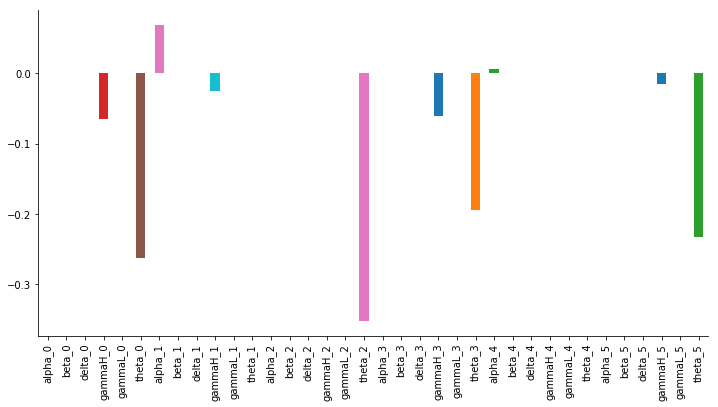

In [36]:
params = {'alpha':[0.1, 0.3, 0.5, 1.0, 1.5, 2.0],
          'l1_ratio': [0.5],
          'penalty': ['elasticnet'],
          'loss': ['log'],
          'max_iter': [100]}

sgd = SGDC(params, metrics)
sgd.fit(X, y)
res = sgd.quick_results(df=True)


fig, ax = plt.subplots(figsize=(12, 6))

feats = sgd.feat_importances()
sorted_idx = sorted(feats.index, key=lambda i: [i[-1], i[:-1]])
feats[sorted_idx].plot(kind='bar', ax=ax)

sns.despine();

## PCA top 10

     C  mean_train_score  mean_test_score
0  0.1          0.707295         0.682927
1  0.3          0.766579         0.658537
2  0.5          0.798437         0.780488
3  1.0          0.826442         0.756098
4  1.5          0.817395         0.756098
5  2.0          0.812454         0.756098

est
----------
LogisticRegression(C=0.5, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=200, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)



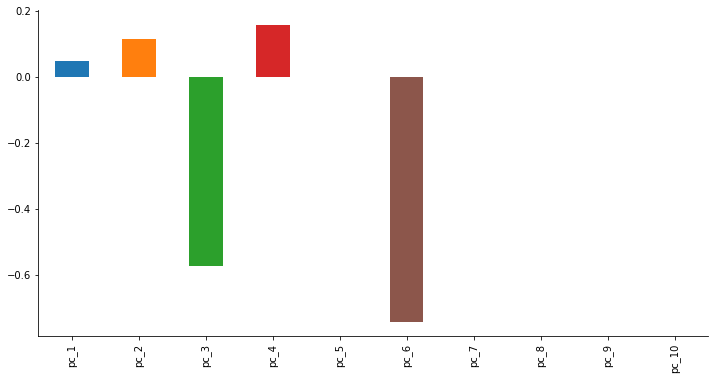

In [24]:
metrics = 'balanced_accuracy'
params = {'C':[0.1, 0.3, 0.5, 1.0, 1.5, 2.0],
          'class_weight': ['balanced'],
          'penalty': ['l1'],
          'solver': ['saga'],
          'max_iter': [200]}
n_components = 10
Xpca = pd.DataFrame(PCA(n_components).fit_transform(X), 
                    columns=['pc_' + str(i) for i in range(1, n_components+1)])
logit = Logit(params, metrics, pca=False)
logit.fit(Xpca, y)
logit.quick_results()

fig, ax = plt.subplots(figsize=(12, 6))

feats = logit.feat_importances()

feats.plot(kind='bar', ax=ax)

sns.despine();